1. Escriba un autoencoder y entrénelo sobre el dataset [Fashion-MNIST](https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist)
    - Use capas convolucionales para el encoder y el decoder
    - Usted debe definir la cantidad de capas, la cantidad de filtros por capa y el tamaño de los filtros
    - Use 2 dimensiones en el cuello de botella (espacio latente)
    - Use activación lineal en el cuello de botella y en la salida
    - Use función de costo `BCEWithLogitsLoss`
1. Visualice el espacio latente del conjunto de test con un scatter plot (coloree cada clase de forma distinta). Describa el resultado y comente sobre las clases más separadas y más "confundidas" en el espacio latente.
1. Encuentre y visualize los diez ejemplos con mayor error de reconstrucción del conjunto de test
1. Mida la calidad de las reconstrucciones en el conjunto de test por clase. ¿Cúales clases son más difíciles de reconstruir?

# Import libraries

In [1]:
import torchvision
import matplotlib.pyplot as plt
import random
import sklearn
from torch.utils.data import DataLoader, Subset
import sklearn.model_selection
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Load data

In [2]:
# Classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [3]:
# Get train data
train_data = torchvision.datasets.FashionMNIST('mnist_fashion_dataset', 
                                               train = True, 
                                               transform = torchvision.transforms.ToTensor(), 
                                               download = True)

# Get test data
test_data = torchvision.datasets.FashionMNIST('mnist_fashion_dataset', 
                                       train=False, 
                                       download=True,
                                       transform=torchvision.transforms.ToTensor())

# Display data

Label:  Bag


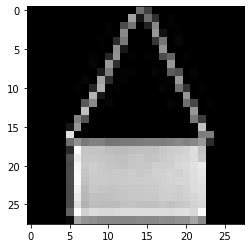

In [4]:
# get image
image = train_data[random.randint(0, len(train_data))]

print('Label: ', classes[image[1]])

# plot image
plt.figure()
plt.imshow(image[0].numpy()[0, :, :], cmap = 'gray')

# Create Data Loader

In [38]:
# Get spliting data ids
sss = sklearn.model_selection.StratifiedShuffleSplit(train_size = 0.6)
train_idx, valid_idx = next(sss.split(np.zeros(len(train_data)), train_data.targets))

# Get subset for training
train_dataset = Subset(train_data, train_idx)

# Get dataloader for trainnig
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)

# Get subset for validation
valid_dataset = Subset(train_data, valid_idx)

# Get dataloader for validation
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=256)

# Get test data loader
test_loader = DataLoader(test_data, shuffle=False, batch_size=256)

# Define Model

- Use capas convolucionales para el encoder y el decoder
- Usted debe definir la cantidad de capas, la cantidad de filtros por capa y el tamaño de los filtros
- Use 2 dimensiones en el cuello de botella (espacio latente)
- Use activación lineal en el cuello de botella y en la salida
- Use función de costo BCEWithLogitsLoss

## Comentarios:
Se itera sobre varios hyperparameters hasta alcanzar una arquitectura que logre representar de forma clara las clases en las 2 variables latentes.

In [6]:
class conv_autoencoder(torch.nn.Module):
    
    # Define architecture
    def __init__(self):
        
        super(conv_autoencoder, self).__init__()
        
        latent_var = 2
        
        # Not work
#         num_kernels_conv1 = 4
#         num_kernesl_conv2 = 3
#         latent_input = 588

#         num_kernels_conv1 = 2
#         num_kernesl_conv2 = 2
#         latent_input = 392
        
#         num_kernels_conv1 = 2
#         num_kernesl_conv2 = 2
#         latent_input = 392
        
        num_kernels_conv1 = 2
        num_kernesl_conv2 = 2
        latent_input = 392
        
        # Encoder
        self.conv1 = torch.nn.Conv2d(1, num_kernels_conv1, kernel_size = 3, stride = 1, padding = 1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = torch.nn.Conv2d(num_kernels_conv1, num_kernesl_conv2, kernel_size = 3, stride = 1, padding = 1)
        
        # Activation not linear
        self.act = torch.nn.ReLU()
        
        # Latent 
        self.latent = torch.nn.Linear(latent_input, latent_var)
        
        # Decoder
        self.dec_lin1 = torch.nn.Linear(latent_var, latent_input)
        self.deconv1 = torch.nn.ConvTranspose2d(num_kernels_conv1, num_kernesl_conv2, kernel_size = 2, stride = 2)
        self.deconv2 = torch.nn.ConvTranspose2d(num_kernesl_conv2, 1, kernel_size = 3, padding = 1)
        
    
    def encode(self, x, batch_size):
        
#         # size of minibatch
#         input_size = x.size(0) 
        
#         print('input encode: ', x.size())
        
        # Conv 1
        tmp = self.act(self.conv1(x))
        
#         print('out conv 1: ', tmp.size())
        
        # Pool
        tmp = self.pool1(tmp)
        
#         print('out pool 1: ', tmp.size())
        
        # Conv 2
        tmp = self.act(self.conv2(tmp))
        
#         print('out conv 2: ', tmp.size())
        
        # flatten (reshape)
        tmp = tmp.view(batch_size, -1)
        
#         print('out flatten: ', tmp.size())
        
        # Latent
        tmp = self.act(self.latent(tmp))
        
#         print('out latent: ', tmp.size())
        
        return tmp
        
    def decode(self, z, batch_size):
        
#         print('input decode: ', z.size())
        
        tmp = self.dec_lin1(z)
        
#         print('output dec lin 1: ', tmp.size())
        
        # Unflutten
        tmp = tmp.view(-1, 2, 14, 14)
        
#         print('out reshape: ', tmp.size())
        
        tmp = self.act(self.deconv1(tmp))
        
#         print('out deconv1: ', tmp.size())
        
        tmp = self.act(self.deconv2(tmp))
        
#         print('output deconv2: ', tmp.size())
        
        return tmp
    
    def forward(self, x):
        
        batch_size = x.size()[0]
        
#         print('input size: ', x.size())
        
        # Encode
        tmp = self.encode(x, batch_size)
        
        # Decode
        tmp = self.decode(tmp, batch_size)
        
#         print('final output: ', tmp.size())
        
        return tmp
#         return self.decode(z)

# Test if the forward method is correct

In [7]:
model = conv_autoencoder()
# model = fully_con_autoencoder()

image = train_data[2][0]

y = model.forward(image.unsqueeze(0))

# print(y.shape)
# plt.figure()
# plt.imshow(image.numpy()[0, :, :])


# Set model and its configurations

In [8]:
# define model
model = conv_autoencoder()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Loss function
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

# Train model

## Comentarios:

Al observar el valor de pérdida, se tiene que el valor para validación tiene tendencia descendente para todo valor de epoch analizado, por lo que podría seguir iterandose y analizar si es que en algún momento se alcanza un mínimo. Sin embargo se detiene iteración por tiempo de ejecución requerido.

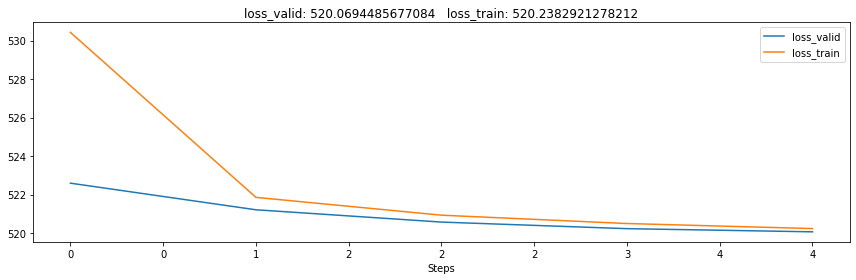

In [9]:
# Hiddenlayer objects to track metrics
import hiddenlayer as hl

history1 = hl.History()
history2 = hl.History()

canvas1 = hl.Canvas()


use_gpu = torch.cuda.is_available()

print('Cuda training: ', use_gpu)

nepochs = 5

if use_gpu:
    
    model = model.cuda()

import time

from torch.utils.tensorboard import SummaryWriter

# tensorboard --logdir=/tmp/tensorboard
# current_time = str(time.time())
# train_writer = SummaryWriter("/tmp/tensorboard/digits/train/", flush_secs=1)
# valid_writer = SummaryWriter("/tmp/tensorboard/digits/valid/", flush_secs=1)

last_valid_loss = 1e8
last_valid_loss_epoch = 0
count_early_stopping = 0

for epoch in range(nepochs): 
    
    print(epoch)
    
    # Train
    epoch_loss_train = 0.0
    
    for mbdata, mblabel in train_loader:
        
        if use_gpu:
            
            mbdata = mbdata.cuda()
            
        prediction = model(mbdata)
        
        optimizer.zero_grad()    
               
#         print('prediction size: ', prediction.size())
#         print('label size: ', mbdata.size())
        
        loss = criterion(prediction, mbdata)
        
        epoch_loss_train += loss.item()
        
        loss.backward()
        
        optimizer.step()
    
#     print(epoch_loss/len(train_idx))
#     train_writer.add_scalar('Loss', epoch_loss/len(train_idx), epoch)
    
    # Validation    
    epoch_loss_valid = 0.0
    for mbdata, mblabel in valid_loader:
        if use_gpu:
            mbdata = mbdata.cuda()
        prediction = model(mbdata)
        loss = criterion(prediction, mbdata)
        epoch_loss_valid += loss.item()
    
#     print(epoch_loss/len(valid_idx))
    
#     valid_writer.add_scalar('Loss', epoch_loss/len(valid_idx), epoch)
    
    history1.log(epoch, loss_valid = epoch_loss_valid/len(valid_idx))
    history2.log(epoch, loss_train=epoch_loss_train/len(train_idx))
    
    with canvas1: # So that they render together
        canvas1.draw_plot([history1["loss_valid"], history2["loss_train"]])
#         canvas1.draw_plot([history1["accuracy_valid"], history2["accuracy_train"]])
        
    # Early stopping
    if last_valid_loss > (epoch_loss_valid/len(valid_idx)):
        
        last_valid_loss = epoch_loss_valid/len(valid_idx)
        last_valid_loss_epoch = epoch
        
        count_early_stopping = 0
        
    else:
        
        if count_early_stopping > 50:
            
            print('Early stopping with best loss value in epoch: ', last_valid_loss_epoch)
            
            # This should stop
        
        else:
            
            count_early_stopping += 1
            print('update early stopping value to: ', count_early_stopping)
        
        
if use_gpu:
    
    model = model.cpu()
    
# train_writer.close()
# valid_writer.close()

# Save and load model (Optional)

In [18]:
# save model
torch.save(model, f = 'autoencoder_model')

/home/leo/Desktop/master_UACH/env/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type conv_autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [20]:
torch.load('autoencoder_model')

conv_autoencoder(
  (conv1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act): ReLU()
  (latent): Linear(in_features=392, out_features=2, bias=True)
  (dec_lin1): Linear(in_features=2, out_features=392, bias=True)
  (deconv1): ConvTranspose2d(2, 2, kernel_size=(2, 2), stride=(2, 2))
  (deconv2): ConvTranspose2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

# Results visualization

## Comentarios:

Se puede ejecutar varias veces el siguiente código para ir viendo las representaciones de instancias.

Shirt


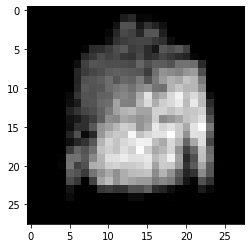

In [22]:
import random

image = test_data[random.randint(0,len(test_data))]

print(classes[image[1]])

y = model.forward(image[0].unsqueeze(0))

# print(y.shape)

plt.figure()

plt.imshow(y.detach()[0,0, :, :], cmap = 'gray')

# Latent representation

1. Visualice el espacio latente del conjunto de test con un scatter plot (coloree cada clase de forma distinta). Describa el resultado y comente sobre las clases más separadas y más "confundidas" en el espacio latente.

In [23]:
z_eval = np.zeros(shape=(len(test_data), 2))

for i, (image, label) in enumerate(test_loader):
    
    z_eval[i*256:(i+1)*256] = model.encode(image, image.size()[0]).detach().numpy()

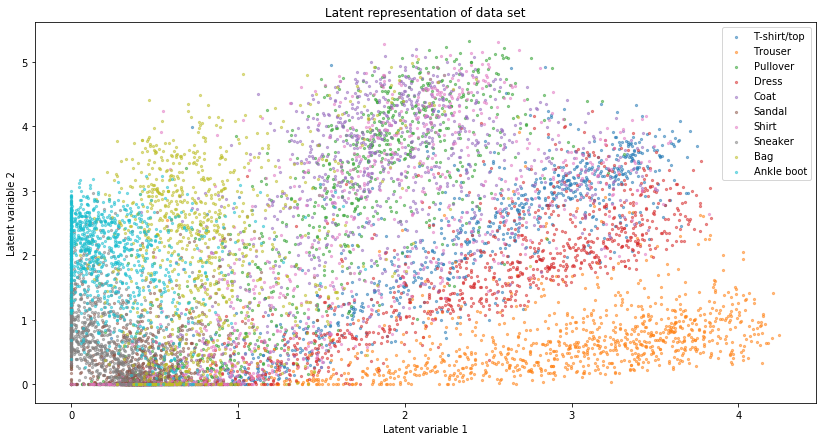

In [24]:
fig, ax = plt.subplots(figsize = (14,7))

for i in range(len(classes)):
    
    ax.scatter(z_eval[test_data.targets.numpy() == i, 0], 
               z_eval[test_data.targets.numpy() == i, 1], 
               s=5, 
               alpha=0.5, 
               label = classes[i])
    
ax.legend()
ax.set_xlabel('Latent variable 1')
ax.set_ylabel('Latent variable 2')
ax.title.set_text('Latent representation of data set')

# REMOVE COLORS BECAUSE MAYBE THESE ARE DIFFERENTS

## Análisis resultados
A partir del gráfico se tiene:

1) Se observa que existen clases que se diferencian en cuan dispersas estan y en cuan solapadas se encuentran.

2) Para el caso de la clase 'Ankle boot' (color parecido al celeste), 'Bag' (amarillo) y 'Trouser' (naranjo), se tiene que estan muy poco solapadas con otras clases, de hecho se puede observar el 'cluster' que forman.

3) Para el caso de la clase 'T-shirt/top' (azul), 'Dress' (rojo) se tienen una baja dispersión de la clase y su solapamiento es leve pero mayor al de las clases del punto (2).

4) Para el caso de las clases 'Pullover' (verde), 'Coat' (morado fuerte) y 'Shirt' (morado debil) se tiene sobrelapamiento entre las 3 clases. Esto se podría exlpicar debido a que las 3 prendas son fisicamente parecidas, por lo que sus formas son semejanes, lo que lleva a tener representaciones similares. Cabe destacar que este solapamiento genera también un 'cluster' separado de las demás clases.

5) Para las clases 'Sneaker' (gris) y 'Sandal' (cafe) se tiene solapamiento, lo que se podría explicar debido a que las prendas son semejantes físicamente. Además estas 2 clases generan un cluster, pero que se encuentra solapado con la siguiente clase, la cual corresponde a la clase 'Ankle boot'. Esto se podría explicar debido a que las formas de 'Ankle boot', 'Sneaker' y 'Sandal' son similares.

6) Existe una zona (cercana al origen de coordenadas), en donde se genera solapamiento entre todas las clases, por lo que es complejo determinar la clase de cada instacia.

## Top 10 in reconstruction 

1. Encuentre y visualize los diez ejemplos con mayor error de reconstrucción del conjunto de test

In [39]:
test_loader_ = DataLoader(test_data, shuffle=False, batch_size=1)

test_loss = np.zeros(len(test_loader_))

for idx, (mbdata, label) in enumerate(test_loader_):
        
        if use_gpu:
            
            mbdata = mbdata.cuda()
            model = model.cuda()
            
        prediction = model(mbdata)
        
        loss = criterion(prediction, mbdata)
        
        test_loss[idx] = loss        

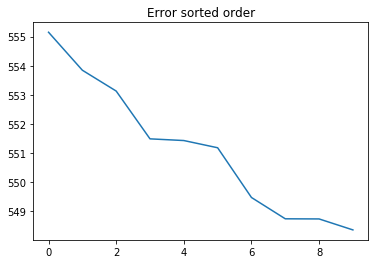

In [44]:
# get id of top 10 greatest erros
idx = np.argsort(test_loss)[::-1][:10]

# plot for check if errors are in sorted order
fig, ax = plt.subplots()
ax.plot(test_loss[idx])
ax.title.set_text('Error sorted order')

El gráfico es solo para verificar que estan en orden

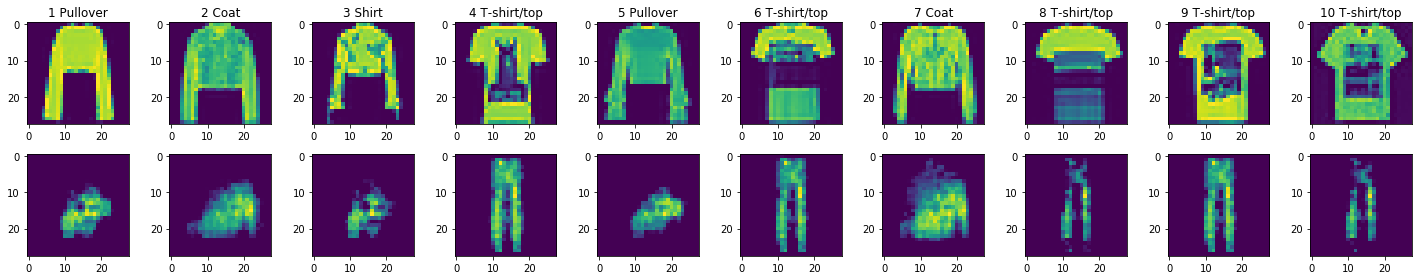

In [78]:
# Get subset for training
test_data_ = Subset(test_data, idx)

# Get dataloader for trainnig
test_loader_ = DataLoader(test_data_, shuffle = False, batch_size = 1)

# create plot
fig, ax = plt.subplots(2, 10, figsize = (20,4), tight_layout = True)

# Iterate through test loader
for idx_, (data, labels) in enumerate(test_loader_):
    
    # GPU allocate
    if use_gpu:
        
        model = model.cuda()
        data = data.cuda()
    
    # get prediction
    prediction = model(data)

    # Plot input
    ax[0, idx_].imshow(data[0].cpu().numpy()[0, :, :])
    title = str(idx_ + 1) + ' ' + classes[labels]
    ax[0, idx_].title.set_text(title)
    
    # plot ouput
    ax[1, idx_].imshow(prediction.detach().cpu().numpy()[0,0, :, :])
    
# Allocate in CPU
if use_gpu:
    
    model = model.cpu()

En la primera fila se tienen los inputs y en la segunda fila se tiene los outputs obtenidos desde el modelo. Se observan las instancias con mayor error con respecto a su input. 

Para los inputs 1, 2, 3, 5 y 7, se tienen que los outputs generados no poseen ninguna forma clara que asemeje la forma del input, lo que genera alto valor de error. 

Para el 4, 6, 8, 9 y 10 input, se tiene un output de otra clase (lo que genera gran valor de loss). Cabe destacar que para todos los casos, la clase input es 'Tshirt' y la de salida es 'Trouser'.

A continuación se presentan las imágenes en su representación en variable latente, en donde se observa que todos están en zonas 'difusas', en donde no es claro la clase a la que pertenecen.

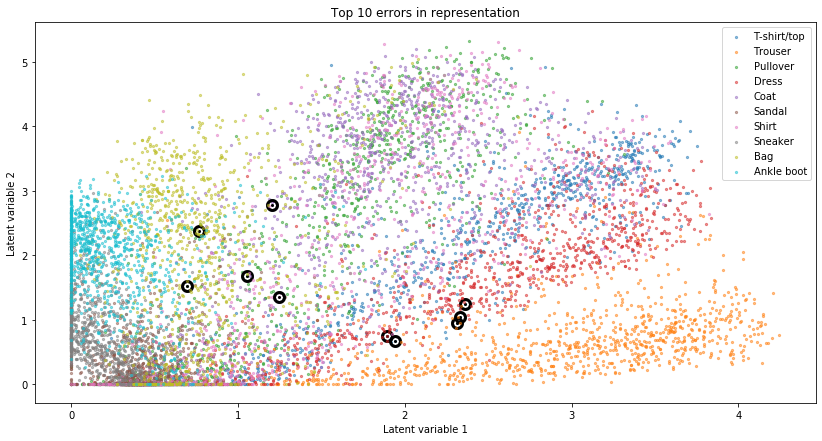

In [150]:
fig, ax = plt.subplots(figsize = (14,7))

# mask for top 10 erros
mask_top_10 = np.zeros(len(test_data), dtype=bool)
mask_top_10[idx] = True

for i in range(len(classes)):
    
    ax.scatter(z_eval[test_data.targets.numpy() == i, 0], 
               z_eval[test_data.targets.numpy() == i, 1], 
               s=5, 
               alpha = 0.5, 
               label = classes[i])
    
    mask = (test_data.targets.numpy() == i)
    
#     print(mask)
    
    ax.scatter(z_eval[mask & mask_top_10, 0], 
              z_eval[mask & mask_top_10, 1], marker = '.', linewidth = 10, color = 'black')
    
# print(z_eval[idx, 0].size, z_eval[idx, 1].size)

ax.legend()
ax.set_xlabel('Latent variable 1')
ax.set_ylabel('Latent variable 2')
ax.title.set_text('Top 10 errors in representation')

## Mida la calidad de las reconstrucciones en el conjunto de test por clase. ¿Cúales clases son más difíciles de reconstruir?

Text(0.5, 0, 'Class')

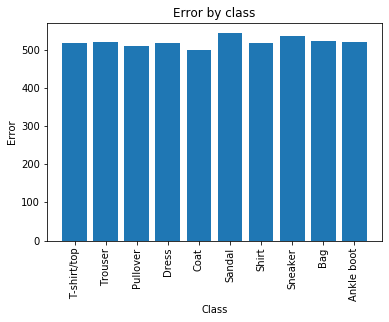

In [167]:
loss_by_class = []

# iterate through each class
for i in range(len(classes)):
    
    # Filter by class
    mask_class = (test_data.targets.numpy() == i)
    
#     print(len(test_data))
#     print(len(mask_class))
#     print(np.sum(mask_class))
    # get instances of the class
#     print(np.sum(test_loss[mask_class]))
    loss_class = np.sum(test_loss[mask_class])/np.sum(mask_class)
    
    loss_by_class.append(loss_class)
    
fig, ax = plt.subplots()

ax.bar(x = np.arange(10), height = loss_by_class)
ax.set_xticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.tick_params(axis='x', rotation=90)
ax.title.set_text('Error by class')
ax.set_ylabel('Error')
ax.set_xlabel('Class')

# Análisis
Del gráfico se observa que la clase mas difícil de reconstruir corresponde a 'Sandal', la cual se destaca en el siguiene gráfico. Se observa que corresponde a la clase que está ubicada en el origen de coordenadas, la cual corresponde una zona en donde se genera gran solapamiento de todas las clases, lo que hace complejo definir claramente la clase.

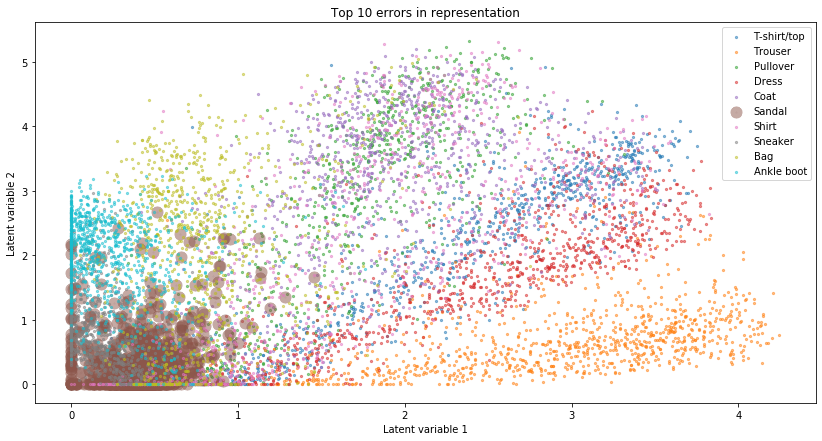

In [175]:
fig, ax = plt.subplots(figsize = (14,7))

for i in range(len(classes)):
    
    if i != 5:
        
        ax.scatter(z_eval[test_data.targets.numpy() == i, 0], 
                   z_eval[test_data.targets.numpy() == i, 1], 
                   s=5, 
                   alpha = 0.5, 
                   label = classes[i])
    else:
        
        ax.scatter(z_eval[test_data.targets.numpy() == i, 0], 
               z_eval[test_data.targets.numpy() == i, 1], 
               s=5, 
               alpha = 0.5, 
               label = classes[i],
                  marker = '*',
                  linewidth = 10)

ax.legend()
ax.set_xlabel('Latent variable 1')
ax.set_ylabel('Latent variable 2')
ax.title.set_text('Top 10 errors in representation')

La siguiente clase con mayor error corresponde a 'Sneaker', la cual se presenta en el siguiente gráfico. Se observa que al igual que la clase anterior, se tiene una zona en donde se genera gran solapamiento con las demás clases, por lo que es complejo identificarlas claramente.

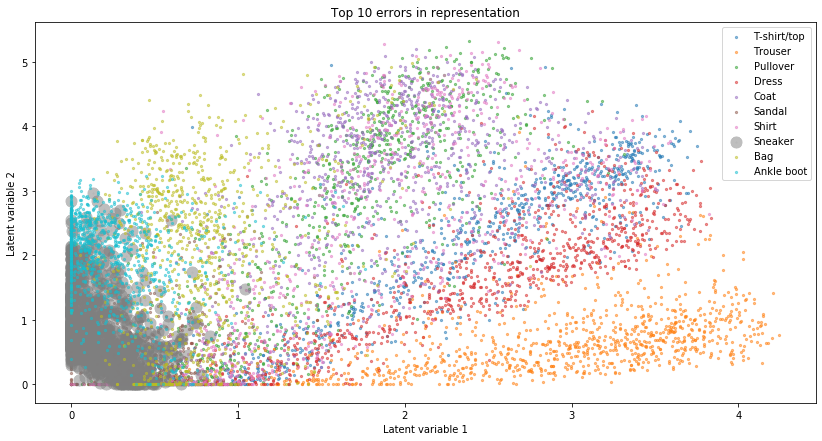

In [178]:
fig, ax = plt.subplots(figsize = (14,7))

for i in range(len(classes)):
    
    if i != 7:
        
        ax.scatter(z_eval[test_data.targets.numpy() == i, 0], 
                   z_eval[test_data.targets.numpy() == i, 1], 
                   s=5, 
                   alpha = 0.5, 
                   label = classes[i])
    else:
        
        ax.scatter(z_eval[test_data.targets.numpy() == i, 0], 
               z_eval[test_data.targets.numpy() == i, 1], 
               s=5, 
               alpha = 0.5, 
               label = classes[i],
                  marker = '*',
                  linewidth = 10)

ax.legend()
ax.set_xlabel('Latent variable 1')
ax.set_ylabel('Latent variable 2')
ax.title.set_text('Top 10 errors in representation')

Del gráfico de erores, se tiene que las demás clases poseen errores similares.

Por otro lado, la clase que mas error posee, corresponde a 'Coat', la cual es destacada en el siguiente gráifico. Se observa que la mayoría de la clase se ubica fuera de la zona del origen por lo que su solapamiento con todas las demás clases debería ser menor. Sin embargo, se observa gran solapamiento con la clase 'Pullover' y 'Tshirt' (tal como se analizó en puntos anteriores). 

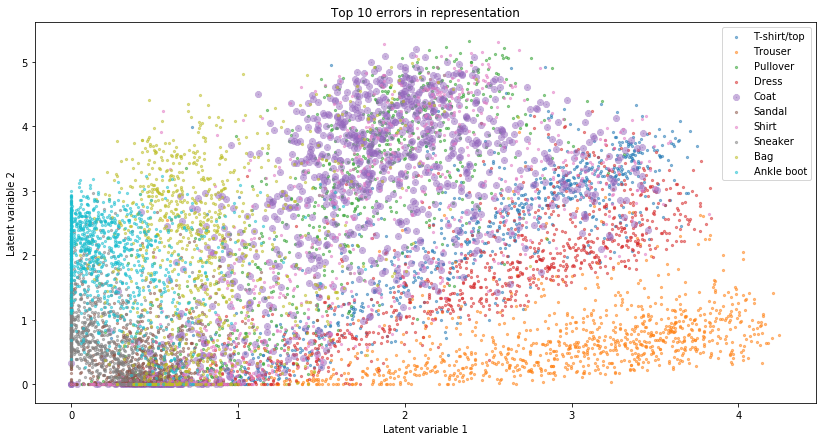

In [196]:
fig, ax = plt.subplots(figsize = (14,7))

for i in range(len(classes)):
    
    if i != 4:
        
        ax.scatter(z_eval[test_data.targets.numpy() == i, 0], 
                   z_eval[test_data.targets.numpy() == i, 1], 
                   s=5, 
                   alpha = 0.5, 
                   label = classes[i])
    else:
        
        ax.scatter(z_eval[test_data.targets.numpy() == i, 0], 
               z_eval[test_data.targets.numpy() == i, 1], 
               s=5, 
               alpha = 0.5, 
               label = classes[i],
                  marker = '*',
                  linewidth = 5)

ax.legend()
ax.set_xlabel('Latent variable 1')
ax.set_ylabel('Latent variable 2')
ax.title.set_text('Top 10 errors in representation')